<a href="https://colab.research.google.com/github/joaxkal/SDM/blob/master/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from random import randint, uniform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.metrics.cluster import normalized_mutual_info_score
from datetime import datetime
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from scipy import stats
import time
import random
import pandas as pd
import os

In [0]:
class Kmeans:

    def __init__(self, k, points):
      self.k=k
      self.points = points.copy()
      self.centroids=np.full(shape=(self.k,self.points.shape[1]), 
                             fill_value=-1, dtype=np.float64)

      # auxiliary columns: point_id, assigned cluster, distance to cluster
      points_aux=np.full(shape=(self.points.shape[0], 3),fill_value=-1)
      points_aux[:, 0]=np.arange(start=0, stop=self.points.shape[0])
      self.points=np.append(self.points, points_aux, axis=1)
      
      # auxiliary columns: centroid id, counts of assigned points
      centroids_aux=np.full(shape=(self.k, 2),fill_value=0)
      centroids_aux[:, 0]=np.arange(start=0, stop=self.k)
      self.centroids=np.append(self.centroids,centroids_aux,axis=1 )


    # method used in Lloyd and initialization
    def calculate_all_centroids(self):
      for k in range(self.k):
        self.centroids[k,:-2] = \
          self.points[self.points[:,-2]==k][:, :-3].mean(axis=0)
        self.centroids[k,-1] = len(self.points[self.points[:,-2]==k][:, -3])
    
  
   # method used in MacQueen - recalculates old and new centroid
    def calculate_two_centroids(self, point, old_cen, new_cen):

      #update old centroid
      old_cen[:-2] = old_cen[:-2] * old_cen[-1] - point[:-3]                
      old_cen[-1] = old_cen[-1] - 1
      old_cen[:-2] = old_cen[:-2] / old_cen[-1]

      #update new centroid
      new_cen[:-2] = new_cen[:-2] * new_cen[-1] + point[:-3]
      new_cen[-1] = new_cen[-1] + 1
      new_cen[:-2] = new_cen[:-2] / new_cen[-1]

      return old_cen, new_cen
             

    # method to assign point to the nearest centroid. 
    # For macqueen if centroid changed - recalculate 2 centroids
    def assign_clusters(self, points, centroids,macqueen=False):
      for point in points:
        dist_min=np.inf
        old_cen=centroids[int(point[-2]), :]
        new_cen=old_cen.copy()
        for cen in centroids:
            diff = point[:-3] - cen[:-2]
            dist = np.inner(diff,diff)
            if dist < dist_min:
              dist_min = dist
              new_cen = cen
        if new_cen[-2]!=old_cen[-2] and macqueen==True:
            old_cen, new_cen = self.calculate_two_centroids(
                point, old_cen, new_cen)
            centroids[int(old_cen[-2]), :] = old_cen
            centroids[int(new_cen[-2]),:] = new_cen
        point[-2]=new_cen[-2].copy()
        point[-1]=dist_min 

      return points, centroids



    def initialize_clusters(self, method='forgy'):
      self.points[:,-2]=-1
      self.points[:,-1]=-1

      if method=='forgy':
        # assign random cluster to each point
        while any(k not in self.points[:,-2] for k in range(0,self.k)):
          self.points[:,-2]=np.random.randint(
              0, self.k, self.points.shape[0])
        self.calculate_all_centroids()
        
      if method == "kmpp":
        # auxiliary column: probability, create new matrix 'points_aux'for it
        probability=np.full(shape=(self.points.shape[0], 1),fill_value=-1)
        points_aux=np.append(self.points, probability, axis=1)

        for i in range(0,self.k):
            if i == 0:
                # Take one center c1, chosen uniformly at random from X .
                initial=randint(0,self.k)
                self.centroids[i,0:-2] = points_aux[initial,0:-4].copy()
                self.centroids[i,-2]=i
                self.centroids[i,-1]=points_aux.shape[0]
                        
            else:
                # Take a new center ci choosing x ∈ X with probability 
                points_aux[:, :-1], self.centroids[:i,:]=self.assign_clusters(
                    points_aux[:, :-1].copy(), self.centroids[:i,:].copy())
                # calculate square distance
                points_aux[-2]=points_aux[-2].copy()**2
                sum_of_distance=np.sum(points_aux[:,-2])
                points_aux[-1]=points_aux[-2]/sum_of_distance
                # choose  new centroid with probability D^2(x) / sum  x∈X D^2(x)
                select_random=uniform(0,1)
                cumulant=0
                for j in range(points_aux.shape[0]):
                    cumulant = cumulant + points_aux[j, -2]
                    if select_random <= cumulant:
                      self.centroids[i, :-2] = points_aux[j,:-4].copy()
                      break
        # assign points to the nearest clusters and recalculate
        self.points, self.centroids = self.assign_clusters(
              self.points.copy(), self.centroids.copy())
        self.calculate_all_centroids()

      if method=='robin':
        clf = LocalOutlierFactor(n_neighbors=3, novelty=True)
        # temporary auxiliary column (only for i=0): robin_dist
        # create new matrix 'points_aux'for it
        robin_dist=np.full(shape=(self.points.shape[0], 1),fill_value=-1)
        points_aux=np.append(self.points, robin_dist, axis=1)
        
        for i in range(0,self.k):
          if i==0:
            # select random point r
            random=randint(0,self.k)
            r=self.points[random,:].copy() 
            points_aux[:,-1]=np.linalg.norm(
                points_aux[:,:-4]-r[:-3],axis=1)
            # sort descending by distance to r, drop temporary column
            points_aux=points_aux[points_aux[:, -1].argsort()[::-1]][:,:-1]

          else:
            points_aux, self.centroids[:i,:]=self.assign_clusters(
                points_aux[:,:].copy(), self.centroids[:i,:].copy())
            # sort descending by distance to the closest centroid
            points_aux=points_aux[points_aux[:, -1].argsort()[::-1]]
                  
          for pt in points_aux:
            tmp=np.delete(points_aux, int(pt[-3]), axis=0)[:,0:-3]
            clf.fit(tmp)
            LOF=clf.predict(pt[0:-3].reshape(1, -1))
            if LOF[0]==1:
              self.centroids[i,:-2]=pt[:-3].copy()
              break
      # assign points to the nearest clusters and recalculate
      self.points, self.centroids = self.assign_clusters(
            self.points.copy(), self.centroids.copy())
      self.calculate_all_centroids()

    def plot_clusters(self, points, centroids, i):
        #select subset of dataframe with features
        X = points[:,:-3]
        y = points[:,-2]
       
        X_c = centroids[:,:-2]
        y_c = centroids[:,-2]
       
        if X.shape[1] == 2:
            method = 'Plot'
            X_reduced_pca = X
            X_c_reduced_pca = X_c
        else:
            method = 'PCA'
            # calculate PCA Implementation of dim reducition
            pca=PCA(n_components=2, random_state=42)
            pca.fit(X)
            X_reduced_pca = pca.transform(X)
            X_c_reduced_pca = pca.transform(X_c)

        #plotting
        f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
        f.suptitle('Iteration ' + str(i), fontsize=14)

        # scatter plot
        ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1],
                    c=y, cmap='coolwarm', linewidths=4)
        ax1.scatter(X_c_reduced_pca[:,0], X_c_reduced_pca[:,1],
                    c=y_c, marker='x',
                    s=250, cmap='summer', linewidths=12)
        ax1.set_title(method, fontsize=14)
        ax1.grid(True)

        plt.show()


    def MacQueen(self, make_plots=False):
        i=0
        while True:
          #print('ITERATION', i, datetime.now())
          if make_plots:
            self.plot_clusters(self.points, self.centroids, i)   

          clusters_before = self.points[:,-2].copy()
          self.points, self.centroids = self.assign_clusters(
              self.points.copy(), self.centroids.copy(), macqueen=True)
          clusters_after = self.points[:,-2].copy()
          #check if algorithm converged
          if not any(c_before != c_after for c_before, c_after 
                     in zip(clusters_before,clusters_after)):
            break
          i=i+1
        self.plot_clusters(self.points, self.centroids, i) 
        return i


    def Lloyd(self, make_plots=False):
      i=0
      while True:
          #print('ITERATION', i, datetime.now())
          if make_plots:
            self.plot_clusters(self.points, self.centroids, i) 

          clusters_before = self.points[:,-2].copy()
          self.points, self.centroids = self.assign_clusters(
              self.points.copy(), self.centroids.copy(),macqueen=False)
          clusters_after = self.points[:,-2].copy()

          #check if algorithm converged
          if not any(c_before != c_after for c_before, c_after 
                     in zip(clusters_before,clusters_after)):
              break
          self.calculate_all_centroids()
          i=i+1
      self.plot_clusters(self.points, self.centroids, i) 
      return i
                      

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
data_htru_raw = np.genfromtxt("/content/gdrive/My Drive/SDM Kmeans/HTRU_2.csv", delimiter=',')
data_htru=data_htru_raw[:, 0:-1].copy()

data_skin_raw=np.genfromtxt("/content/gdrive/My Drive/SDM Kmeans/Skin_NonSkin.txt", delimiter='\t')
data_skin=data_skin_raw[:, 0:-1].copy()  


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#mock data for sanity checks
data=np.array([[1,1,1.5],[2,1,4.5],[3,2,1.5],[4,2,2.5],[5,2,1.5],[6,2,3.5],[7,3,3.5],[8,4,3.5],[9,5,3.5],[10,2,3.3],[11,5,10],[11,8,8]])[:,1:3]
data



array([[ 1. ,  1.5],
       [ 1. ,  4.5],
       [ 2. ,  1.5],
       [ 2. ,  2.5],
       [ 2. ,  1.5],
       [ 2. ,  3.5],
       [ 3. ,  3.5],
       [ 4. ,  3.5],
       [ 5. ,  3.5],
       [ 2. ,  3.3],
       [ 5. , 10. ],
       [ 8. ,  8. ]])

In [0]:
def tester(dataset_name,data, labels, algorithm, init_method, normalize =False,iterations = 2, plots=False):
  #make folder for results
  if not os.path.exists("/content/gdrive/My Drive/SDM Kmeans/results_"+dataset_name):
    os.mkdir("/content/gdrive/My Drive/SDM Kmeans/results_"+dataset_name)
  #set output formatting to fixed-point with 4 decimal places
  float_formatter = "{:.4f}".format
  np.set_printoptions(formatter={'float_kind':float_formatter})

  # Own implementation testing:
  random.seed(a=42)


  #normalize the data?
  if normalize=='StandardScaler':
    scaler=StandardScaler()
    data=scaler.fit_transform(data.copy())
  
  if normalize == 'MinMaxScaler':
    scaler = MinMaxScaler()
    data=scaler.fit_transform(data.copy())

  output = np.zeros((iterations,4))
  description = np.full((iterations,4),'', dtype = 'object')
  for i in range(0,iterations):
    start = time.time()

    ex=Kmeans(2, data)
    ex.initialize_clusters(method=init_method)
      
    if algorithm == 'MacQueen':
       n_of_iter=ex.MacQueen(make_plots=plots)
    else:
       n_of_iter=ex.Lloyd(make_plots=plots)
    own_NMI= normalized_mutual_info_score(labels, ex.points[:,-2])

    #Sklearn clustering to compare
    kmeans = KMeans(n_clusters=2, random_state=randint(0,1000)).fit_predict(data)
    sklearn_NMI=normalized_mutual_info_score(labels, kmeans)
    end = time.time()

    #save results to array
    output[i][0]= own_NMI
    output[i][1]= sklearn_NMI
    output[i][2]= (end - start)
    output[i][3]= n_of_iter

    #save description to array
    description[i][0] = dataset_name
    description[i][1] = algorithm
    description[i][2] = init_method 
    description[i][3] = normalize  

  #create DataFrame with results
  columns =['datset','algorithm', 'init method', 'normalize', 'NMI', 
            'sklearn NMI', 'time', 'iterations']
  results =  np.concatenate((description,output), axis=1)
  results = pd.DataFrame(results, columns=columns)

  #save results to csv file
  #results.to_csv("/content/gdrive/My Drive/SDM Kmeans/results_"+dataset_name
  #               +'/'+algorithm+'_'+init_method+'_'+str(normalize)+'.csv',sep=';')
  
  #get summary statistics
  stat_desc=stats.describe(output)
  summary =  np.concatenate((description[0],stat_desc.mean, 
                             (stat_desc.variance)**(1/2), stat_desc.minmax[0], 
                             stat_desc.minmax[1], stat_desc.skewness, 
                             stat_desc.kurtosis), axis=0)
  columns =[('info','dataset'),('info','algorithm'), ('info','init method'), 
            ('info','normalize'), ('mean','NMI'), ('mean','sklearn NMI'), 
            ('mean','time'),('mean','iterations'),\
    ('std','NMI'), ('std','sklearn NMI'), ('std','time'),('std','iterations'),\
    ('min','NMI'), ('min','sklearn NMI'), ('min','time'),('min','iterations'),\
    ('max','NMI'), ('max','sklearn NMI'), ('max','time'),('max','iterations'),\
    ('skewness','NMI'), ('skewness','sklearn NMI'), ('skewness','time'),('skewness','iterations'),\
    ('kurtosis','NMI'), ('kurtosis','sklearn NMI'), ('kurtosis','time'),('kurtosis','iterations')\
    ]
  results_summary = pd.DataFrame(summary.reshape(1,-1))
  results_summary.columns=pd.MultiIndex.from_tuples(columns)
  return results_summary


In [6]:
"""
df_results=pd.DataFrame([])
for algorithm in ["Lloyd" , "MacQueen"]:
  for init_method in ["robin","kmpp","forgy"]:
    for normalization in [False, "MinMaxScaler", "StandardScaler"]:
        print(algorithm, init_method,normalization)
        result=tester('HTRU_2',data_htru, data_htru_raw[:,-1], algorithm, 
                      init_method, normalization,100)
        df_results=pd.concat([df_results,result],axis=0)
df_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/HTRU_2_results.csv",sep=',')
df_results
"""

'\ndf_results=pd.DataFrame([])\nfor algorithm in ["Lloyd" , "MacQueen"]:\n  for init_method in ["robin","kmpp","forgy"]:\n    for normalization in [False, "MinMaxScaler", "StandardScaler"]:\n        print(algorithm, init_method,normalization)\n        result=tester(\'HTRU_2\',data_htru, data_htru_raw[:,-1], algorithm, \n                      init_method, normalization,100)\n        df_results=pd.concat([df_results,result],axis=0)\ndf_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/HTRU_2_results.csv",sep=\',\')\ndf_results\n'

In [7]:
"""
df_results=pd.DataFrame([])
for algorithm in ["MacQueen"]:
  for init_method in ["robin","kmpp","forgy"]:
    for normalization in [False, "MinMaxScaler", "StandardScaler"]:
        print(algorithm,init_method,normalization)
        result=tester('skin',data_skin, data_skin_raw[:,-1], algorithm, 
                      init_method, normalization,100)
        df_results=pd.concat([df_results,result],axis=0)
df_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/skin_results.csv",sep=',')
df_results
"""

'\ndf_results=pd.DataFrame([])\nfor algorithm in ["MacQueen"]:\n  for init_method in ["robin","kmpp","forgy"]:\n    for normalization in [False, "MinMaxScaler", "StandardScaler"]:\n        print(algorithm,init_method,normalization)\n        result=tester(\'skin\',data_skin, data_skin_raw[:,-1], algorithm, \n                      init_method, normalization,100)\n        df_results=pd.concat([df_results,result],axis=0)\ndf_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/skin_results.csv",sep=\',\')\ndf_results\n'

In [8]:
"""
df_results=pd.DataFrame([])
for algorithm in ["Lloyd"]:
  for init_method in ["robin","kmpp","forgy"]:
    for normalization in [False, "MinMaxScaler", "StandardScaler"]:
        print(algorithm,init_method,normalization)
        result=tester('skin',data_skin, data_skin_raw[:,-1], algorithm, 
                      init_method, normalization,100)
        df_results=pd.concat([df_results,result],axis=0)
df_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/skin_results2.csv",sep=',')
df_results
"""

'\ndf_results=pd.DataFrame([])\nfor algorithm in ["Lloyd"]:\n  for init_method in ["robin","kmpp","forgy"]:\n    for normalization in [False, "MinMaxScaler", "StandardScaler"]:\n        print(algorithm,init_method,normalization)\n        result=tester(\'skin\',data_skin, data_skin_raw[:,-1], algorithm, \n                      init_method, normalization,100)\n        df_results=pd.concat([df_results,result],axis=0)\ndf_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/skin_results2.csv",sep=\',\')\ndf_results\n'

In [9]:
"""
df_results=pd.DataFrame([])
for algorithm in ["MacQueen"]:
  for init_method in ["robin","kmpp","forgy"]:
    for normalization in [False, "MinMaxScaler", "StandardScaler"]:
        print(algorithm,init_method,normalization)
        result=tester('skin',data_skin, data_skin_raw[:,-1], algorithm, 
                      init_method, normalization,100)
        df_results=pd.concat([df_results,result],axis=0)
df_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/skin_results.csv",sep=',')
df_results
"""

'\ndf_results=pd.DataFrame([])\nfor algorithm in ["MacQueen"]:\n  for init_method in ["robin","kmpp","forgy"]:\n    for normalization in [False, "MinMaxScaler", "StandardScaler"]:\n        print(algorithm,init_method,normalization)\n        result=tester(\'skin\',data_skin, data_skin_raw[:,-1], algorithm, \n                      init_method, normalization,100)\n        df_results=pd.concat([df_results,result],axis=0)\ndf_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/skin_results.csv",sep=\',\')\ndf_results\n'

Lloyd robin False


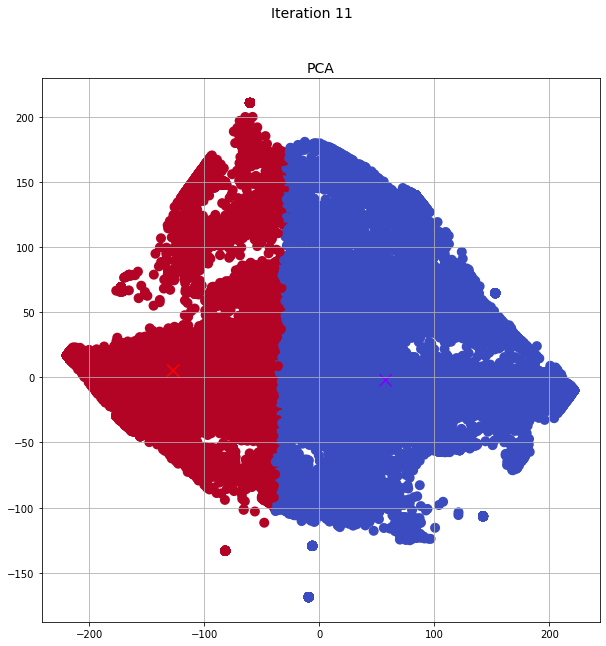

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lloyd robin MinMaxScaler


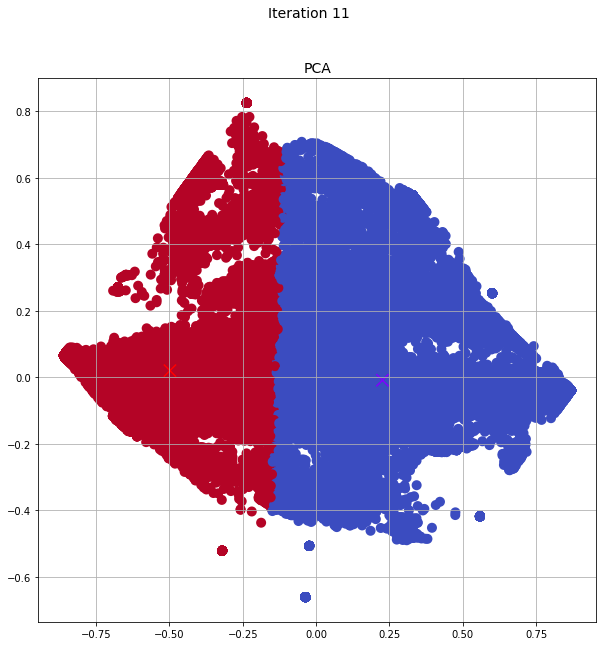

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lloyd robin StandardScaler


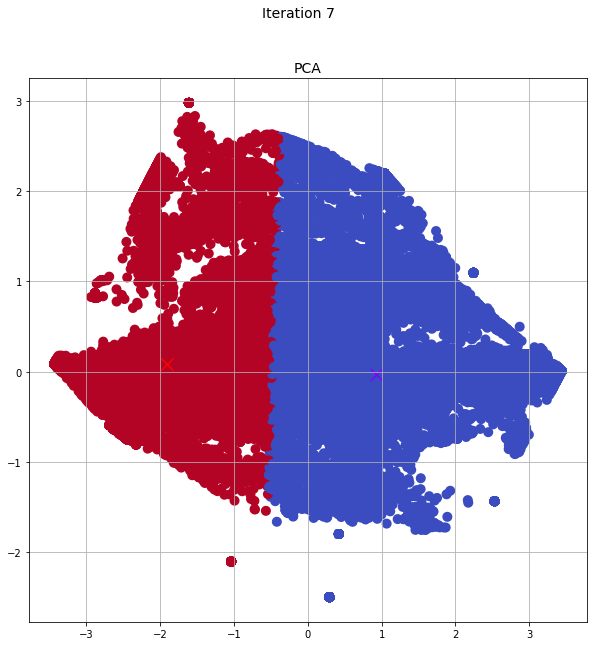

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lloyd kmpp False


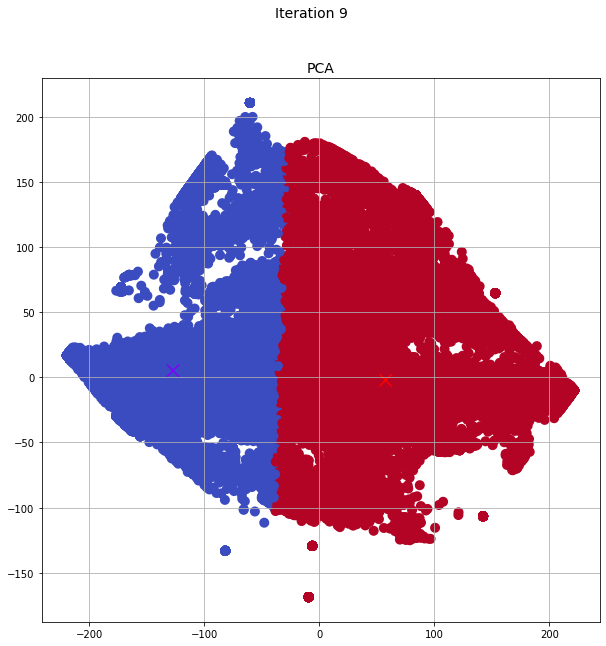

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lloyd kmpp MinMaxScaler


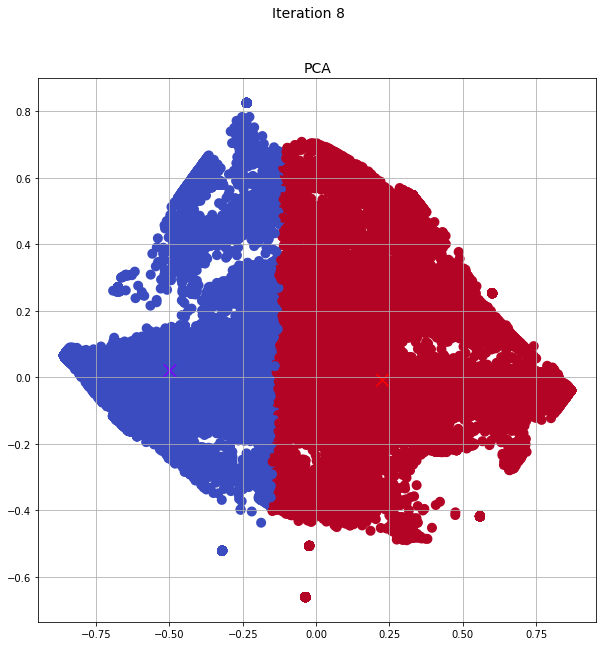

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lloyd kmpp StandardScaler


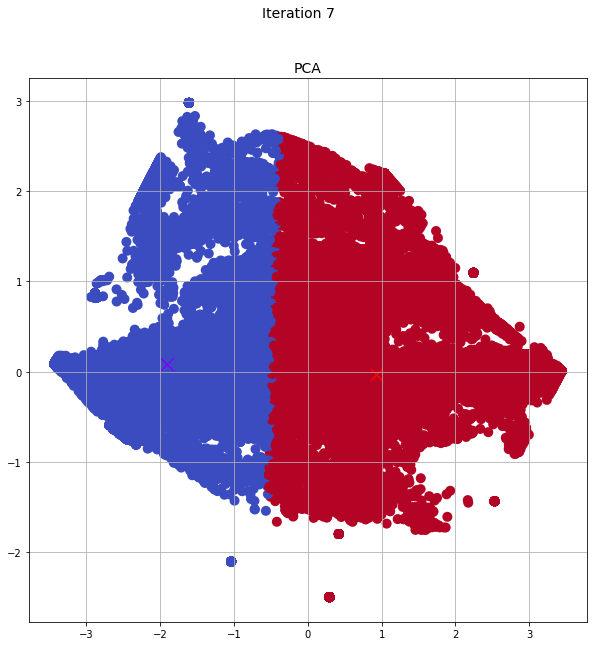

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lloyd forgy False


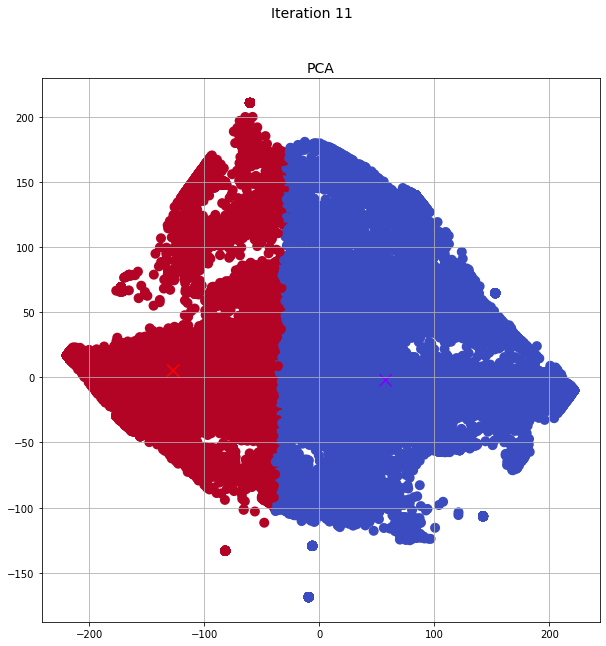

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lloyd forgy MinMaxScaler


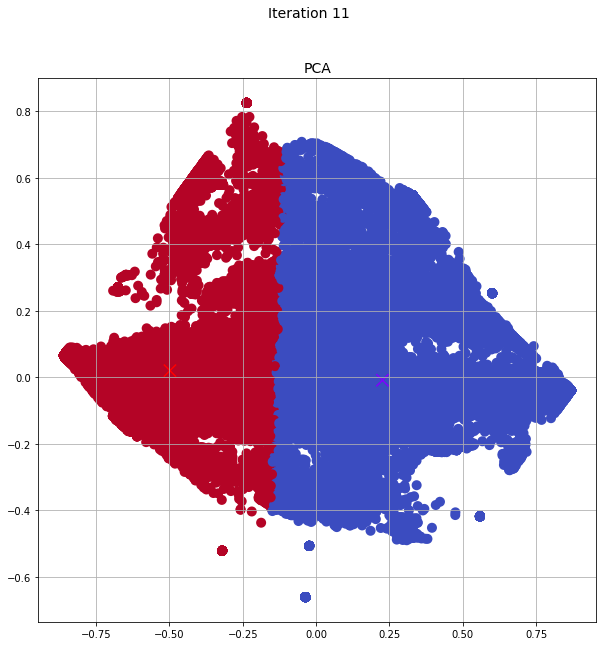

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lloyd forgy StandardScaler


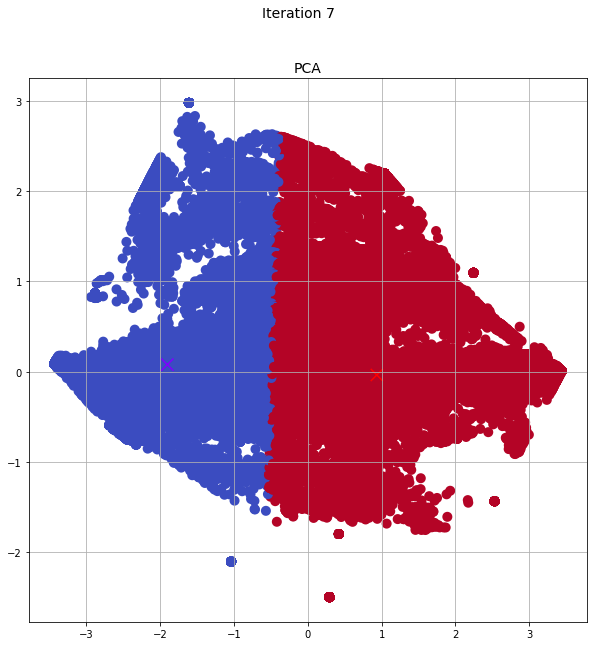

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


MacQueen robin False


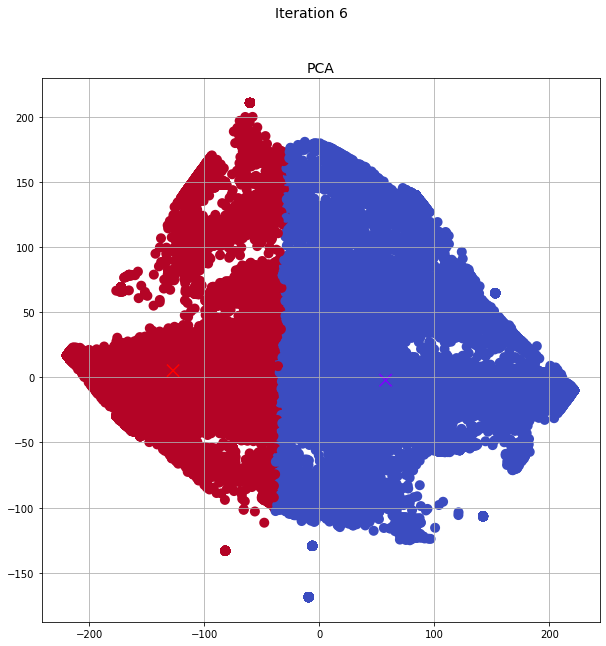

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


MacQueen robin MinMaxScaler


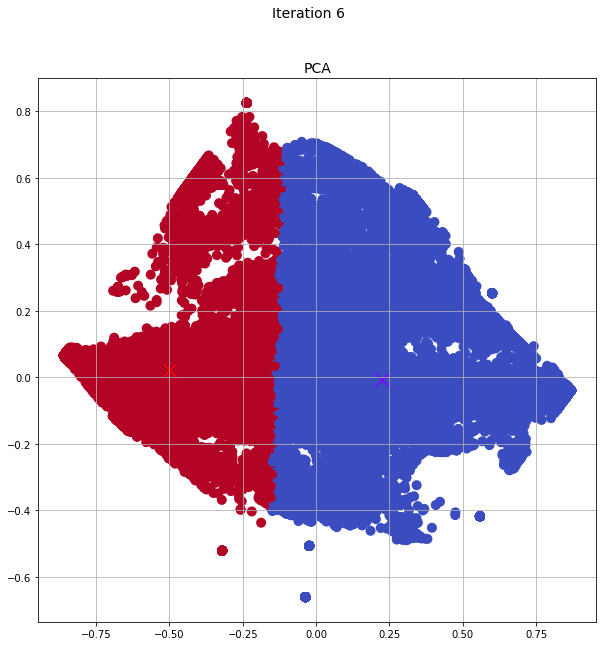

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


MacQueen robin StandardScaler


In [0]:
df_results=pd.DataFrame([])
for algorithm in ["Lloyd","MacQueen"]:
  for init_method in ["robin","kmpp","forgy"]:
    for normalization in [False, "MinMaxScaler", "StandardScaler"]:
        print(algorithm,init_method,normalization)
        result=tester('skin',data_skin, data_skin_raw[:,-1], algorithm, 
                      init_method, normalization,1, plots=False)
        df_results=pd.concat([df_results,result],axis=0)
#df_results.to_csv("/content/gdrive/My Drive/SDM Kmeans/skin_results.csv",sep=',')
df_results